![](https://drive.google.com/uc?id=1vBNDDTuZG6ptoOw2iEEpXKOx3rQCSDiC)

[Image Source](https://www.facebook.com/happywhales)

# **<span style="color:#e76f51;">Goal</span>**
 
The goal of this competition is to develop a model to match individual whales and dolphins by unique—but often subtle—characteristics of their natural markings like dorsal fins and lateral body views .

# **<span style="color:#e76f51;">Data</span>**

The data in this competition contains images of over 15,000 unique individual marine mammals from 30 different species collected from 28 different research organizations. Individuals have been manually identified and given an `individual_id` by marine researches, and your task is to correctly identify these individuals in images. 

`train_images/` - a folder containing the training images

 `train.csv` - provides the species and the individual_id for each of the training images
 
`test_images/` - a folder containing the test images; for each image, your task is to predict the individual_id; no species information is given for the test data; there are individuals in the test data that are not observed in the training data, which should be predicted as new_individual.

`sample_submission.csv` - a sample submission file in the correct format

# **<span style="color:#e76f51;">Metric</span>**

The evaluation metric in the competition's description is Mean Average Precision @ 5 (MAP@5):
$$MAP@5 = {1 \over U} \sum_{u=1}^{U} \sum_{k=1}^{min(n,5)}P(k)  × rel(k)$$

where `U` is the number of images, `P(k)` is the precision at cutoff `k`, rel(k)  is an indicator function equaling 1 if the item at rank k is a relevant (correct) label, zero otherwise and `n` is the number of predictions per image.



<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67">

> I will be integrating W&B for visualizations and logging artifacts!
> 
> [Happy Whale - Involutional Neural Networks](https://wandb.ai/usharengaraju/InvolutionalNN)


> 
> - To get the API key, create an account in the [website](https://wandb.ai/site) .
> - Use secrets to use API Keys more securely 

In [1]:
!pip install tensorflow_addons

In [2]:
import os
import re
import os
import numpy as np
import pandas as pd
import random
import math
import pickle
import json

import wandb

from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from kaggle_datasets import KaggleDatasets

from functools import partial


import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as tfhub
from tensorflow.keras import backend as K
import tensorflow_addons as tfa

import cv2

# Set seed for reproducibility.
tf.random.set_seed(42)

#ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

ROOT_PATH = '../input/happy-whale-and-dolphin'
IMGS_DIR = f'{ROOT_PATH}/train_images'

2022-02-22 02:26:53.286620: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-22 02:26:53.286740: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("api_key")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
CONFIG = dict(competition = 'InvolutionalNN',_wandb_kernel = 'tensorgirl')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **<span style="color:#e76f51;">Data PreProcessing</span>**

Code for preprocessing and Visualization is inspired from the following Sources [1](https://www.kaggle.com/ayuraj/happywhale-eda-ids-to-images-using-w-b-tables) [2](https://www.kaggle.com/abhranta/starter-eda-aug) [3](https://www.kaggle.com/newra008/happywhale-explore)
[4](https://www.kaggle.com/rajankumar/visuals-of-happywhale)



In [4]:
# code copied from https://www.kaggle.com/newra008/happywhale-explore
train_df = pd.read_csv("../input/happy-whale-and-dolphin/train.csv")
train_df.loc[train_df.species.str.contains('beluga'), 'species'] = 'beluga_whale'
train_df.loc[train_df.species.str.contains('globis'), 'species'] = 'globis_whale'

train_df['species'] = train_df['species'].str.replace('bottlenose_dolpin','bottlenose_dolphin')
train_df['species'] = train_df['species'].str.replace('kiler_whale','killer_whale')

train_df['class'] = train_df.species.map(lambda x: 'dolphin' if 'dolphin' in x else 'whale')

# **<span style="color:#e76f51;">Species Distribution - Whale vs Dolphin</span>**

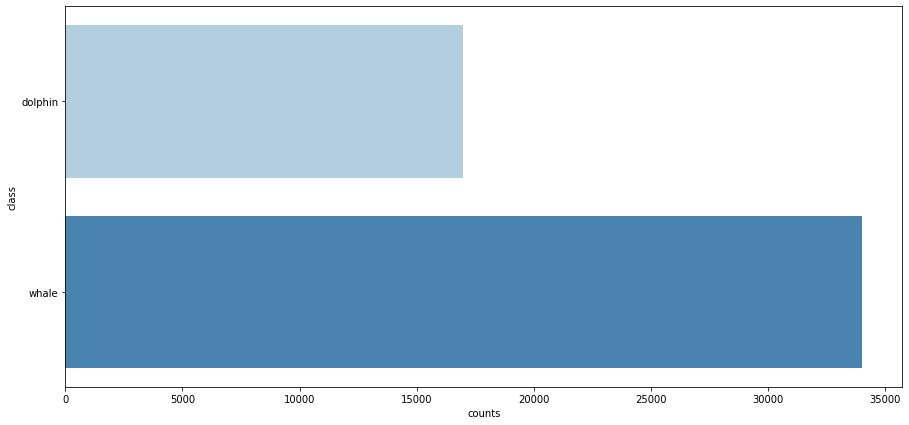

In [5]:
# Let's look at the train image by species class
fig, ax = plt.subplots(figsize=(15, 7))
class_count = train_df.groupby(['class']).size().reset_index(name='counts')
sns.barplot(x = class_count['counts'],y = class_count['class'],data = class_count,palette = "Blues") 
plt.show()

# **<span style="color:#e76f51;">Most Frequently Occuring Individual IDs</span>**

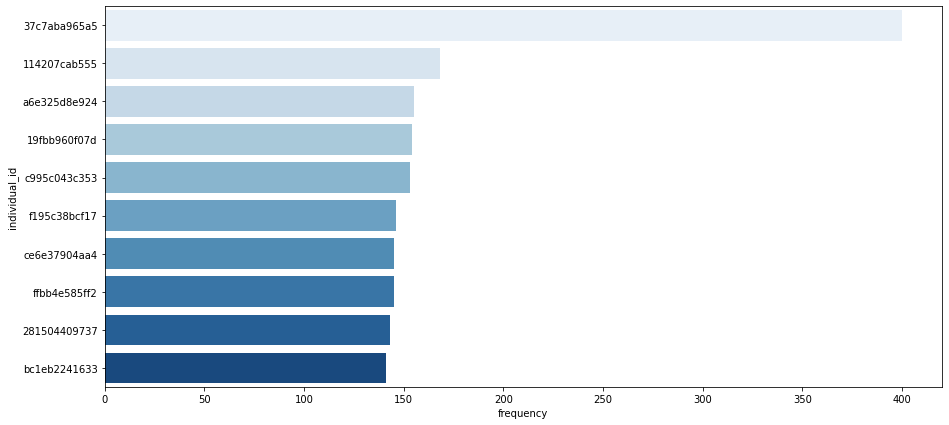

In [6]:
# code copied from https://www.kaggle.com/newra008/happywhale-explore
fig, ax = plt.subplots(figsize=(15, 7))
most_frequent_ids = train_df.individual_id.value_counts().head(10)
most_frequent_ids = pd.DataFrame({'individual_id':most_frequent_ids.index, 'frequency':most_frequent_ids.values})
sns.barplot(y = most_frequent_ids['individual_id'],x = most_frequent_ids['frequency'],data = most_frequent_ids,palette = "Blues")
plt.show()

# **<span style="color:#e76f51;">Dolphin Subspecies Distribution</span>**

Text(0.5, 1.0, 'Dolphin')

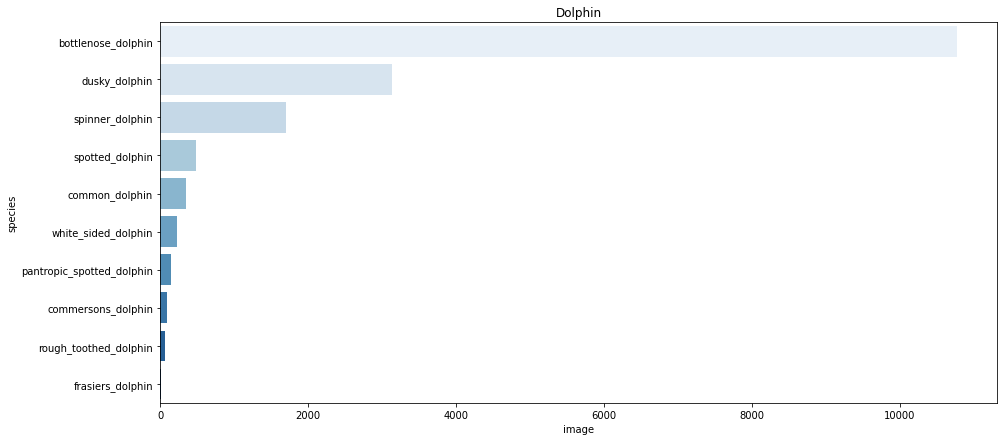

In [7]:
# code copied from https://www.kaggle.com/rajankumar/visuals-of-happywhale
fig, ax = plt.subplots(figsize=(15, 7))
dolphin_count = train_df[train_df['class'] == 'dolphin'].groupby('species').image.count()
dolphin_count = pd.DataFrame(dolphin_count.sort_values(ascending = False))
sns.barplot(data = dolphin_count, y = dolphin_count.index, x = 'image', palette = "Blues")
plt.title('Dolphin')

# **<span style="color:#e76f51;">Whale Subspecies Distribution</span>**

Text(0.5, 1.0, 'Whale')

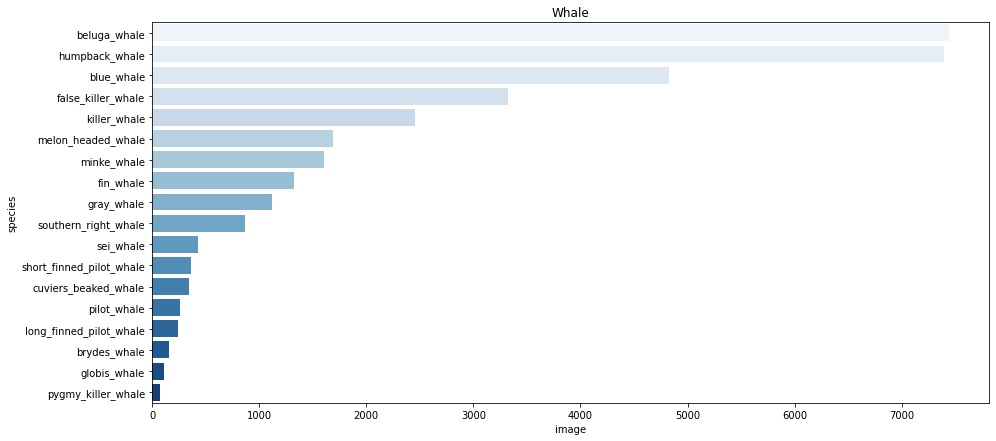

In [8]:
# code copied from https://www.kaggle.com/rajankumar/visuals-of-happywhale
fig, ax = plt.subplots(figsize=(15, 7))
whale_count = train_df[train_df['class'] == 'whale'].groupby('species').image.count()
whale_count = pd.DataFrame(whale_count.sort_values(ascending = False))
sns.barplot(data = whale_count, y = whale_count.index, x = 'image', palette = "Blues")
plt.title('Whale')

# **<span style="color:#e76f51;">Species distribution by Individual IDs</span>**

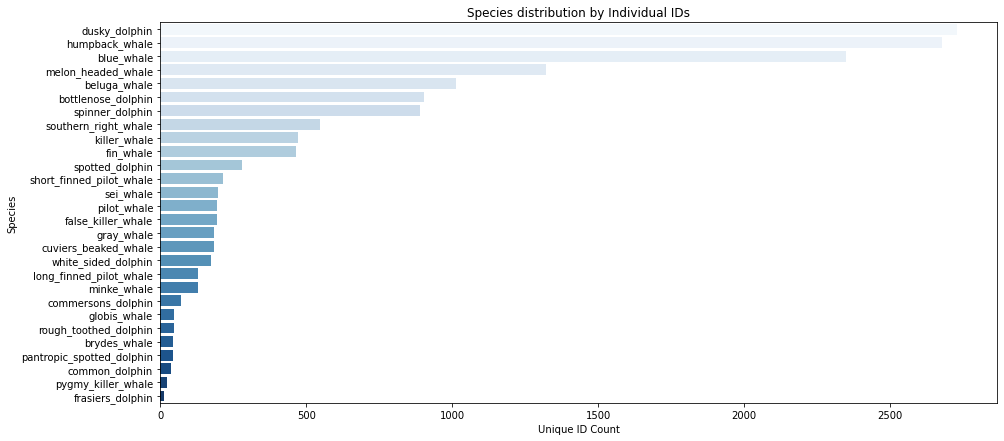

In [9]:
# code copied from https://www.kaggle.com/abhranta/starter-eda-aug
id_perspecies = train_df.groupby(["species"])["individual_id"].nunique()
id_perspecies = pd.DataFrame({'Species': id_perspecies.index,'Unique ID Count': id_perspecies.values})
id_perspecies = id_perspecies.sort_values(['Unique ID Count'], ascending=False)
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Species distribution by Individual IDs')
sns.barplot(y = 'Species', x="Unique ID Count", data=id_perspecies ,palette = "Blues")
plt.show()

# **<span style="color:#e76f51;">Visualizing Whales</span>**

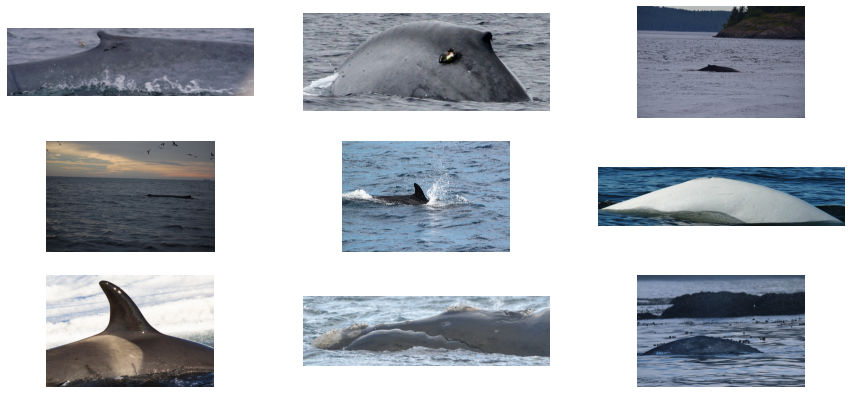

In [10]:
sample_whale = train_df[train_df["class"] == 'whale'].sample(9)
fig, ax = plt.subplots(figsize=(15, 7))  
for ind, (image_id, label) in enumerate(zip(sample_whale.image, sample_whale.species)):
    plt.subplot(3, 3, ind + 1)
    image = cv2.imread(os.path.join("../input/happy-whale-and-dolphin/train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

# **<span style="color:#e76f51;">Visualizing Dolphins</span>**

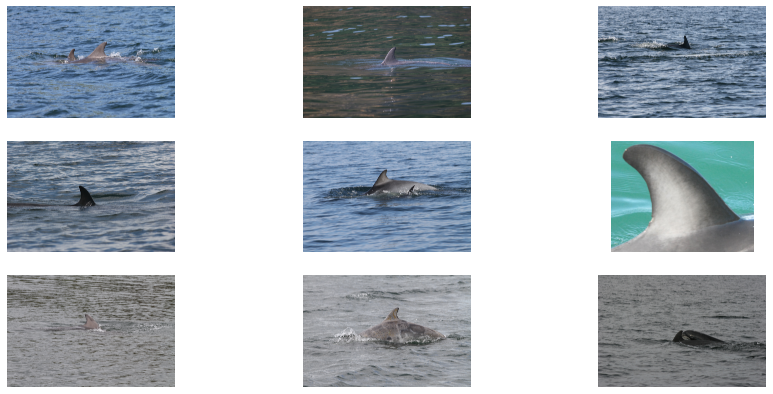

In [11]:
sample_dolphin = train_df[train_df["class"]  == 'dolphin'].sample(9)
fig, ax = plt.subplots(figsize=(15, 7))
for ind, (image_id, label) in enumerate(zip(sample_dolphin.image, sample_dolphin.species)):
    plt.subplot(3, 3, ind + 1)
    image = cv2.imread(os.path.join("../input/happy-whale-and-dolphin/train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()


# **<span style="color:#e76f51;">Map individual_id to Images using W&B Tables</span>**

[Source](https://docs.wandb.ai/guides/data-vis/tables)

W&B Tables are used to log and visualize data and model predictions. Interactively explore your data:

📌 Compare changes precisely across models, epochs, or individual examples

📌 Understand higher-level patterns in your data

📌 Capture and communicate your insights with visual samples


In [12]:
# code copied from https://www.kaggle.com/ayuraj/happywhale-eda-ids-to-images-using-w-b-tables
# Initialize a W&B run
run = wandb.init(project='InvolutionalNN')

train_df1 = train_df.sample(1000)

# Initialize an empty W&B Table
data_table = wandb.Table(columns=['individual_id', 'image_1', 'image_2', 'image_3', 'image_4', 'image_5'])

for unique_id, tmp_df in tqdm(train_df1.groupby('individual_id')):
    if len(tmp_df) > 5:
        # Sample 5 images randomly
        sample_imgs = random.sample(list(tmp_df.image.values), 5)
        # Add data to the table row-wise
        data_table.add_data(unique_id,
                            wandb.Image(f'{IMGS_DIR}/{sample_imgs[0]}'),
                            wandb.Image(f'{IMGS_DIR}/{sample_imgs[1]}'),
                            wandb.Image(f'{IMGS_DIR}/{sample_imgs[2]}'),
                            wandb.Image(f'{IMGS_DIR}/{sample_imgs[3]}'),
                            wandb.Image(f'{IMGS_DIR}/{sample_imgs[4]}'))
        
# Log the table
wandb.log({'mapping_table': data_table})

# Finish the run
wandb.finish()

wandb: Currently logged in as: usharengaraju (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-02-22 02:27:16.321496: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-22 02:27:16.321771: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


  0%|          | 0/836 [00:00<?, ?it/s]


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



# **<span style="color:#e76f51;">TPU Intialization and Distribution Strategy </span>**


![](https://drive.google.com/uc?id=1q6AUi9XZRRWBjov49PSl3thB9idGsUKV)

Tensor Processing Units (TPUs) are Google's custom-developed application-specific integrated circuits (ASICs) used to accelerate machine learning workloads.It's easy to run replicated models on Cloud TPU using High-level Tensorflow APIs .

### **<span style="color:#e76f51;">Performance</span>**

TPU can achieve a high computational throughput on massive multiplications and additions for neural networks , at blazingly fast speeds with much less power consumption and smaller footprint.

📌 **TPU Initialization:** TPUs  are usually on Cloud TPU workers and hence have to be connected to remote clusters and then initialized .

📌 **Distribution strategies :** A distribution strategy is an abstraction that can be used to drive models on CPU, GPUs or TPUs.

In [13]:

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-02-22 02:27:43.432712: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-22 02:27:43.436182: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-22 02:27:43.436222: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-22 02:27:43.436248: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (564de5529056): /proc/driver/nvidia/version does not exist
2022-02-22 02:27:43.439050: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


<div class="alert alert-block alert-info">
<b>Note:</b> TPUs read data directly from <code>Google Cloud Storage (GCS)</code> This Kaggle utility will copy the dataset to a GCS bucket co-located with the TPU. If you have multiple datasets attached to the notebook, you can pass the name of a specific dataset to the <code>get_gcs_path function</code>. The name of the dataset is the name of the directory it is mounted in. Use <code>!ls /kaggle/input/</code> to list attached datasets.
</div>

# **<span style="color:#e76f51;">TF Records</span>**

📌TF-Record is Tensorflow’s own binary storage format.

📌Any byte-string that can be decoded in TensorFlow could be stored in a TFRecord file. Examples include: Lines of text, JSON ,encoded image data, or serialized tf.Tensors .

📌A TFRecord file contains a sequence of records and can only be read sequentially.Each record contains a byte-string, for the data-payload, plus the data-length, and CRC32C (32-bit CRC using the Castagnoli polynomial) hashes for integrity checking.

In [14]:
GCS_PATH = KaggleDatasets().get_gcs_path('happywhale-tfrecords-v1')    
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [256, 256]

2022-02-22 02:27:50.190339: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-22 02:27:50.272360: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


### **<span style="color:#e76f51;">Train-Validation-Test Split</span>**

![](https://drive.google.com/uc?id=1qomd1gdCbw7CA-vdlqtBWAYqsU6-aCtN)

Image Source : mc.ai

In [15]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec'),
    test_size=0.1, random_state=42
)
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')

2022-02-22 02:27:50.643835: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-22 02:27:50.713770: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# **<span style="color:#e76f51;">TF-Data</span>**

![](https://drive.google.com/uc?id=10M07nrMGrKKVP0KGwAqsm7oNK1mXexsD)

📌The tf.data API enables you to build complex input pipelines from simple, reusable pieces. The tf.data API also makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

📌The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

🎯 **Input Pipeline :**

 tf.data.TFRecordDataset() is used to create an input pipeline for data stored in TFRecord format .
 
🎯 **Transformations :**

The Dataset object can be transformed into a new Dataset by chaining method calls on the tf.data.Dataset object . Some of the transformations which can be applied are Dataset.map() , Dataset.batch() , Dataset.shuffle() , Dataset.prefetch() .

The Dataset object is a Python iterable which  it possible to consume its elements using a for loop .


In [16]:
def decode_to_tensor(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_to_tensor(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset




# **<span style="color:#e76f51;">Data Augmentation</span>**

🎯  Data augmentation is a technique through which one can increase the size of the data for the training of the model without adding the new data. Techniques like padding, cropping, rotating, and flipping are the most common methods that are used over the images to increase the data size. 

<div class="alert alert-block alert-info">
<b>Note:</b> Both <code>Keras Preprocessing Layers</code> and <code>tf.image</code> can be used for data augmentation. For finer control , <code>tf.image</code> is preferred.
</div>


In [17]:
def augmentation_pipeline(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(augmentation_pipeline, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print(
    'Dataset: {} training images, {} validation images, {} unlabeled test images'.format(
        NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES
    )
)

Dataset: 45930 training images, 5103 validation images, 27956 unlabeled test images


### <span style="color:#e76f51;">Cyclic Learning Rate</span>

<div class="alert alert-block alert-info">
Cyclic learning rates  is a learning rate scheduling technique for (1) faster training of a network and (2) a finer understanding of the optimal learning rate. Cyclic learning rates have an effect on the model training process known somewhat fancifully as<code>"superconvergence"</code> 
</div>

Source : @residentmario Notebook

![](https://drive.google.com/uc?id=1bnsglJByd1lc1h9hGrz2WZa1LzVBgtWW)

Image Source : https://arxiv.org/abs/1803.09820

In [18]:
def build_lrfn(lr_start=0.00001, lr_max=0.000075, lr_min=0.000001, lr_rampup_epochs=20, lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

# **<span style="color:#e76f51;">Involutional Neural Networks</span>**


[Source](https://arxiv.org/pdf/2103.06255.pdf)

Involutions has symmetrically inverse inherent characteristics like spatial-specific and channel-agnostic . Some of the advantages of Involution over Convolution are 

📌 Ivolution could summarize the context in a wider spatial arrangement, thus overcome the difficulty of modeling long-range interactions well

📌 Ivolution could adaptively allocate


![](https://drive.google.com/uc?id=17dqDpHWpLAXnWfV40EDNoWOTbl1bGUZD)

In [19]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel

In [20]:
with strategy.scope():
# Build the involution model.

    train_dataset = get_training_dataset()
    valid_dataset = get_validation_dataset()
    
    print("building the involution model...")

    inputs = keras.Input(shape=(512, 512, 3))
    x, _ = Involution(
        channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
    )(inputs)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x, _ = Involution(
        channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
    )(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x, _ = Involution(
        channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
    )(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    outputs = keras.layers.Dense(10)(x)

    inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")
    
    inv_model.compile(
            optimizer = tf.keras.optimizers.Adam(),
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            )
    
inv_model.summary()

building the involution model...
Model: "inv_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
inv_1 (Involution)           ((None, 512, 512, 3), (No 26        
_________________________________________________________________
re_lu (ReLU)                 (None, 512, 512, 3)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 3)       0         
_________________________________________________________________
inv_2 (Involution)           ((None, 256, 256, 3), (No 26        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 256, 3)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPool

# **<span style="color:#e76f51;">Paper Summary </span>**

Involution is defined as the inverse operation of convolution . While Convolution is spatial agnostic and channel specific , Involution is spatial specific and channel agnostic .The above implies Involution kernels are unique in spatial space whereas they are shared across channels .

Involution marries Convolution and self attention with a twist . Involutional Neural Networks retains only the query and positional embedding and discards the Key Vector .

### **<span style="color:#e76f51;">RedNet :</span>**


RedNet architecture is constructed from ResNet by replacing the 3 × 3 convolutions with 3 × 3 Involutions . 1 × 1 convolution responsible  for channel projection and fusion is retained . 

### **<span style="color:#e76f51;">Performance in Image Classification :</span>**

RedNet significantly outperforms other state of the art self attention architectures in image classification tasks.

![](https://drive.google.com/uc?id=1uM2dI0GDIF4SLU_-rJnCSbpzxbkCGKCh)

### **<span style="color:#e76f51;">Acknowledgements</span>**

Google supported this work by providing Google Cloud credit

Aritra Roy Gosthipaty work on Involutional Neural Network inspired me to write this notebook

### **<span style="color:#e76f51;">Attributions</span>**

https://www.kaggle.com/ayuraj/happywhale-eda-ids-to-images-using-w-b-tables

https://docs.wandb.ai/guides/data-vis/tables

https://www.kaggle.com/abhranta/starter-eda-aug

https://www.kaggle.com/newra008/happywhale-explore

https://www.kaggle.com/rajankumar/visuals-of-happywhale

https://www.kaggle.com/ks2019/happywhale-tfrecords

https://www.kaggle.com/ks2019/happywhale-arcface-baseline-tpu

https://arxiv.org/pdf/2103.06255.pdf

[Involutional Neural Networks](https://github.com/keras-team/keras-io/blob/master/examples/vision/involution.py)

### Work in progress 🚧